# Código

## Carga de librerías

In [1]:
import zipfile
from PIL import Image
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import uuid

## Carga de información

La información proviene de: [Kaggle](https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving). La base original tiene dos carpetas con información separada, esta fue integrada previamente en dos carpetas. La siguiente sección carga las imágenes:

In [5]:
train_path = './data/training_set'
validation_path = './data/validation_set'
folders = os.listdir(train_path)


def read_images_from_raw(path):
    """Lee las imágenes ubicadas en el path ingresado. Omite archivos con: Image.UnidentifiedImageError 

    Args:
        path (str): path donde se encuentran los archivos 

    Returns:
        images_raw: lista con imágenes agregadas en formato str PIL.
        images_type: lista con etiqueta de imágenes obtenida del sub-path en el que se encuentran 
    """
    
    images_raw = []
    images_type = []
    images_file_path = []
    corrupted_images = 0
    # se revisa cada folder que corresponde a cada tipo de imagen:
    for folder in folders:
        base_path = os.path.join(path, folder)
        for file in os.listdir(base_path):
            file_path = os.path.join(base_path, file)
        # Read the image file
            try:
                with Image.open(file_path) as image:
                    images_raw.append(image.convert('RGBA'))
                    images_type.append(folder)
                    images_file_path.append(file_path)
                # count += 1

            except Image.UnidentifiedImageError:
                corrupted_images += 1
    print(f'{len(images_raw)} imágenes agregadas')
    print(f'{corrupted_images} no pudieron ser incluidas')
    return images_raw, images_type, images_file_path

images_raw, images_type, images_file_path = read_images_from_raw(train_path)


c:\Users\Santiago\miniconda3\envs\ML_BigData\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8188 imágenes agregadas
108 no pudieron ser incluidas


Se visualiza la primera de las imágenes importadas:

In [8]:
test_image = 2000
print(f'Tipo: {images_type[test_image]}')
print(f'Path: {images_file_path[test_image]}')
plt.imshow(images_raw[test_image])


NameError: name 'images_type' is not defined

Las listas resultado de la función anterior se integran en un único dataframe que permitan organizar y manipular la información de una manera más efectiva:

In [7]:
raw_df = pd.DataFrame({'imagen': images_raw, 'tipo': images_type, 'path': images_file_path})

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   imagen  8188 non-null   object
 1   tipo    8188 non-null   object
 2   path    8188 non-null   object
dtypes: object(3)
memory usage: 192.0+ KB


In [9]:
raw_df.head()

,imagen,tipo,path
0,<PIL.Image.Image image mode=RGB size=644x475 a...,drawings,./data/training_set\drawings\01dee7c857692cce2...
1,<PIL.Image.Image image mode=RGB size=534x700 a...,drawings,./data/training_set\drawings\1007036943.jpg
2,<PIL.Image.Image image mode=RGB size=290x198 a...,drawings,./data/training_set\drawings\10288_mainfoto_05...
3,<PIL.Image.Image image mode=RGB size=290x191 a...,drawings,./data/training_set\drawings\1601_mainfoto_05.jpg
4,<PIL.Image.Image image mode=RGB size=788x567 a...,drawings,./data/training_set\drawings\167176.jpg


Para optimizar futuras consultas, se carga el df a una ubicación local:

In [10]:
raw_df.to_csv('./data/processed_files/images_inventory.csv', index=False)

In [2]:
df = pd.read_csv('./data/processed_files/images_inventory.csv')

In [3]:
df.head()

,imagen,tipo,path
0,<PIL.Image.Image image mode=RGB size=644x475 a...,drawings,./data/training_set\drawings\01dee7c857692cce2...
1,<PIL.Image.Image image mode=RGB size=534x700 a...,drawings,./data/training_set\drawings\1007036943.jpg
2,<PIL.Image.Image image mode=RGB size=290x198 a...,drawings,./data/training_set\drawings\10288_mainfoto_05...
3,<PIL.Image.Image image mode=RGB size=290x191 a...,drawings,./data/training_set\drawings\1601_mainfoto_05.jpg
4,<PIL.Image.Image image mode=RGB size=788x567 a...,drawings,./data/training_set\drawings\167176.jpg


# ET

Las imágenes se transforman como arrays:

In [4]:
def transform_image(img_path, target_size=(150, 150)):
    """Las imágenes original se transforman para que cada una de estas tenga el mismo número de canales y dimensiones. La imagen en img_path se convierte en una de formato RGB

    Args:
        img_path (str): Ubicación de la imagen a transformar
        target_size (tuple, optional): Dimensiones objetivo con las que se estandarizan todas las imágenes. Defaults to (150, 150).

    Returns:
        array: imagen convertida asarray y en RGB
    """
    img = Image.open(img_path)
    img = img.resize((150, 150))
    img_array = np.asarray(img)
    if img_array.ndim == 2:  # Grayscale image
        # Convert grayscale to RGB by stacking the same channel three times
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.ndim == 3 and img_array.shape[2] == 4:  # RGBA image
        # Convert RGBA to RGB by removing the alpha channel
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        pass  # No conversion needed
    return img_array

img_arrays = []
for index, row in df.iterrows():
    img = row['path']
    img_arrays.append(transform_image(img))
    
df['array'] = img_arrays

In [5]:
df.head(2)

,imagen,tipo,path,array
0,<PIL.Image.Image image mode=RGB size=644x475 a...,drawings,./data/training_set\drawings\01dee7c857692cce2...,"[[[254, 255, 253], [253, 255, 255], [253, 255,..."
1,<PIL.Image.Image image mode=RGB size=534x700 a...,drawings,./data/training_set\drawings\1007036943.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


Ejemplo del canal rojo:

In [19]:
img_example = df['array'][3000]

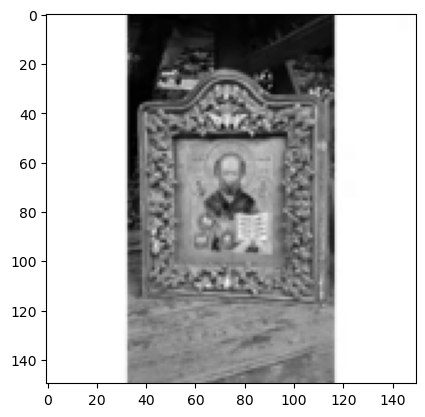

In [20]:
plt.imshow(np.asarray(img_example)[:,:,0], cmap='gray');

Ejemplo del canal verde

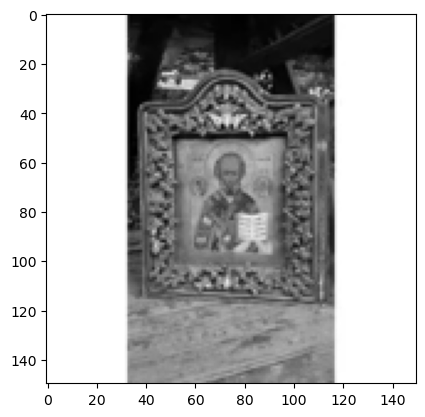

In [21]:
plt.imshow(np.asarray(img_example)[:,:,1], cmap='gray');

Ejemplo del canal azul:

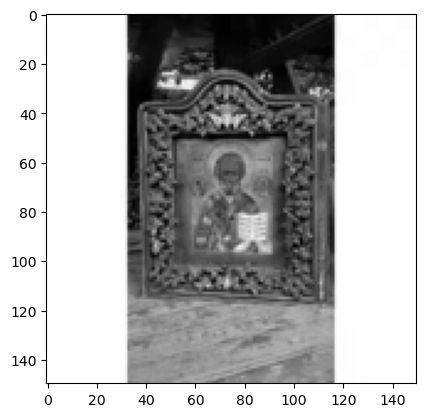

In [22]:
plt.imshow(np.asarray(img_example)[:,:,2], cmap='gray');

Nota: El borde de la imagen es entendido como blancos en la imagen.

In [10]:
np.asarray(img_example).shape

(150, 150, 3)

In [11]:
# error_count = 0
# for image_array in df['array']:
#     image_array = np.asarray(image_array)
#     if image_array.shape != (150, 150, 3):
#         print(image_array.shape)
#         error_count += 1
#     else: 
#         pass
# print(error_count)

# Exploración de datos

## Descripción de la base

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   imagen  8188 non-null   object
 1   tipo    8188 non-null   object
 2   path    8188 non-null   object
 3   array   8188 non-null   object
dtypes: object(4)
memory usage: 256.0+ KB


Text(0, 0.5, 'frecuencia')

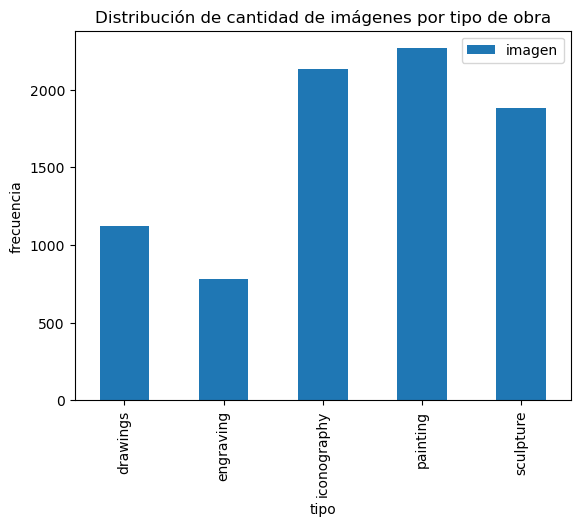

In [ ]:
type_freq = df[['imagen', 'tipo']].groupby(['tipo']).count()
type_freq.plot.bar(column='tipo')
plt.title('Distribución de cantidad de imágenes por tipo de obra')
plt.ylabel('frecuencia')

Histograma de colores

In [12]:
colors = ('b', 'g', 'r')

def generar_histograma(serie):
    histograms = []
    for image_array in serie:
        image_hist = []
        for i, col in enumerate(colors):
            histr = cv2.calcHist([image_array], [i], None, [256], [0,256])
            image_hist.append(histr)
        histograms.append(image_hist)
    return histograms


def plotear_histograma(imagen_arr):
    for i, col in enumerate(colors):
        plt.plot(imagen_arr[i], color=col)
    plt.legend(colors)
    plt.xlabel('Nivel de intensidad')
    plt.ylabel('Cantidad de pixeles')
    
    return

def histograma_promedio(arr):
    stacked_arrays = np.array(arr)
    mean_array = np.mean(stacked_arrays, axis=0)
    return mean_array

Ejemplo de histograma de colores para imagen ejemplo:

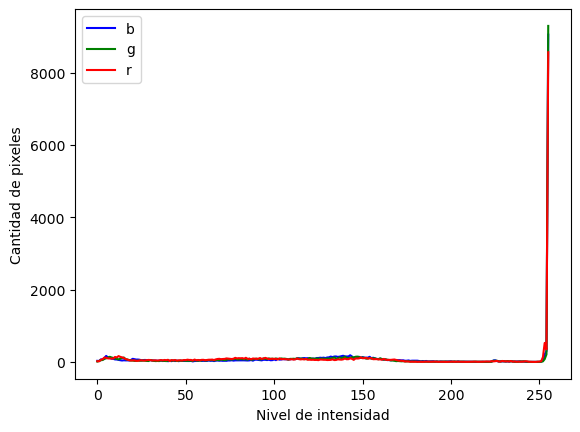

In [18]:
histogramas = generar_histograma(df['array'])
plotear_histograma(histogramas[3000])

Para poder describir de manera grupal los histogramas de las bases de datos, se calcula el histograma con los resultados promedio de todos los canales para todas las imagenes.

In [14]:
mean_array = histograma_promedio(histogramas)

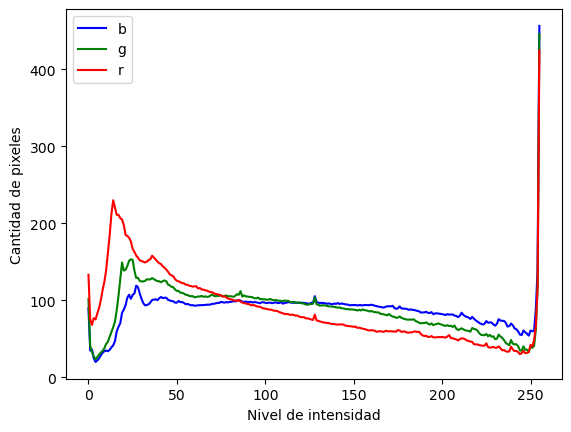

In [15]:
plotear_histograma(mean_array)

Este análisis solo nos muestra que existe en promedio una alta cantidad de áreas brillantes en la totalidad de las fotos. Sin embargo, se quiere revisar las diferencias que existen entre los tipos de histograma para cada uno de los tipos de obras de arte.

## Análisis de histograma promedio por tipo de imagen

Ejemplo de histograma de colores para imagen ejemplo:

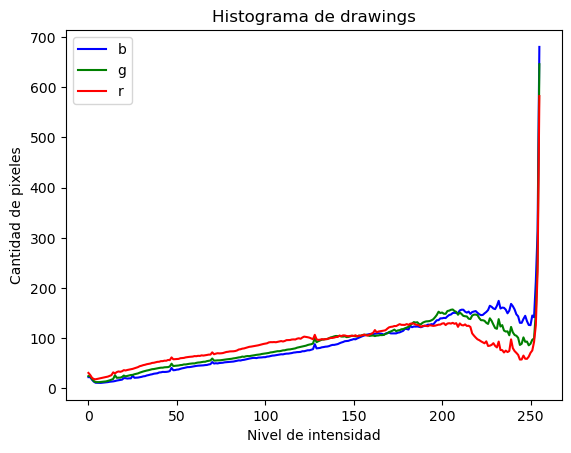

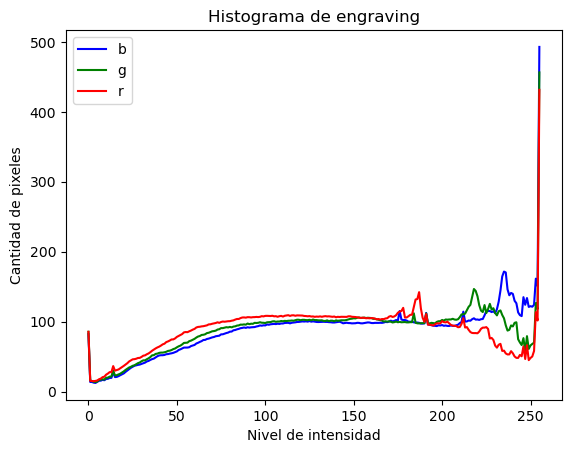

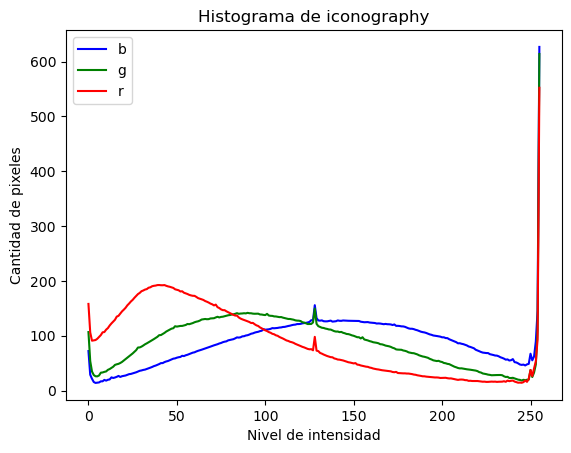

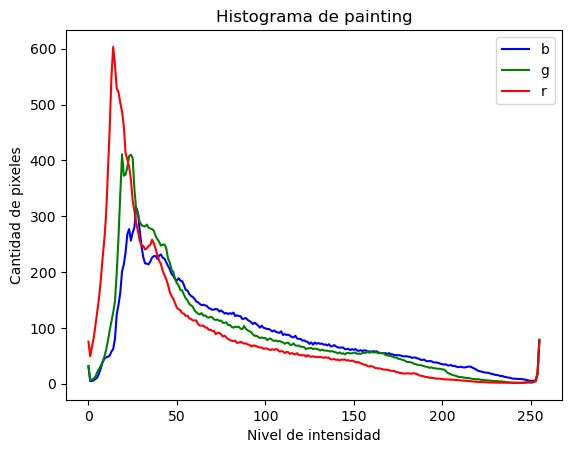

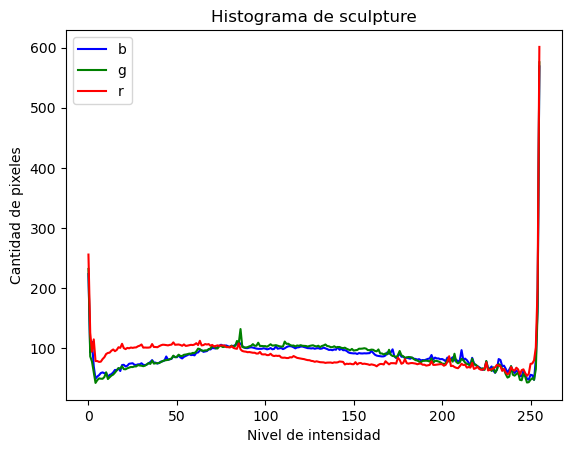

In [17]:
grouped_df = df.groupby('tipo')
for tipo in grouped_df:
    hist = generar_histograma(tipo[1]['array'])
    plt.figure()
    mean_hist = histograma_promedio(hist)
    plotear_histograma(mean_hist)
    plt.title(f'Histograma de {tipo[0]}')
    
    
    